In [1]:
#!pip install yfinance

In [2]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
import yfinance as yf

In [3]:
#Get the Dataset

df = yf.download('TCS', start='2000-01-01', end='2022-10-28')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-01,35.000000,37.000000,32.099998,36.200001,33.839130,14667600
2013-11-04,36.799999,36.799999,34.689999,35.349998,33.044563,1586600
2013-11-05,35.110001,35.500000,34.820000,35.349998,33.044563,337700
2013-11-06,35.610001,36.490002,35.610001,35.900002,33.558697,549600
2013-11-07,36.799999,36.799999,34.119999,35.310001,33.007175,883700


In [4]:
print("Dataframe Shape: ", df. shape)
print("Null Value Present:", df.isnull().values.any())

Dataframe Shape:  (2263, 6)
Null Value Present: False


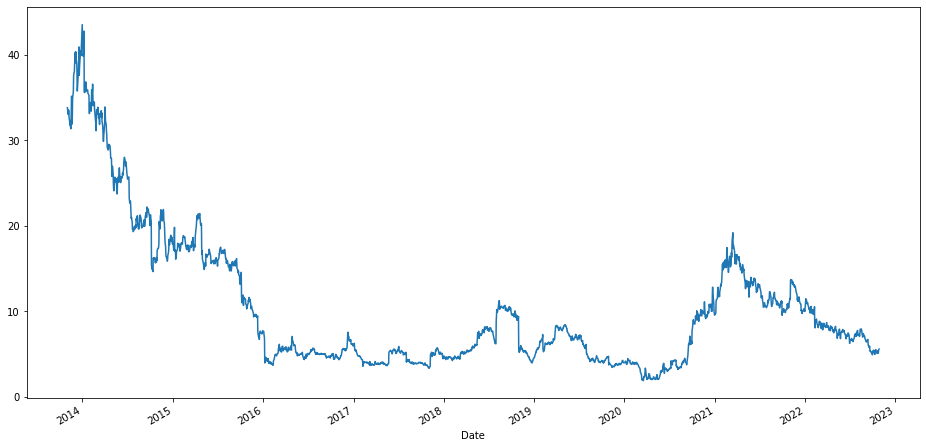

In [5]:
#Plot the True Adj Close Value
plt.figure(figsize=(16, 8))
df['Adj Close'].plot()

In [6]:
#Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [7]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2013-11-01,0.736632,0.776322,0.691781,1.000000
2013-11-04,0.776570,0.771879,0.750913,0.105310
2013-11-05,0.739073,0.743003,0.753881,0.019890
2013-11-06,0.750166,0.764993,0.771918,0.034383
2013-11-07,0.776570,0.771879,0.737900,0.057234


In [8]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=5)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [9]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(128, input_shape=(1, trainX.shape[1]), return_sequences=True))
lstm.add(LSTM(128, return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            68096     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
_________________________________________________________________


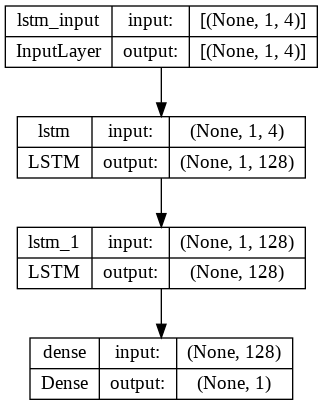

In [11]:
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [12]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False)

Epoch 1/10
1886/1886 [==============================] - 19s 8ms/step - loss: 49.0514
Epoch 2/10
1886/1886 [==============================] - 11s 6ms/step - loss: 1.8889
Epoch 3/10
1886/1886 [==============================] - 8s 4ms/step - loss: 1.0446
Epoch 4/10
1886/1886 [==============================] - 7s 4ms/step - loss: 1.1379
Epoch 5/10
1886/1886 [==============================] - 7s 4ms/step - loss: 1.4407
Epoch 6/10
1886/1886 [==============================] - 8s 4ms/step - loss: 1.5803
Epoch 7/10
1886/1886 [==============================] - 7s 4ms/step - loss: 1.5349
Epoch 8/10
1886/1886 [==============================] - 8s 4ms/step - loss: 1.4594
Epoch 9/10
1886/1886 [==============================] - 8s 4ms/step - loss: 1.3877
Epoch 10/10
1886/1886 [==============================] - 7s 4ms/step - loss: 1.3315


In [13]:
#LSTM Prediction
y_pred= lstm.predict(X_test)
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

12/12 [==============================] - 1s 3ms/step


0.4724946818870322

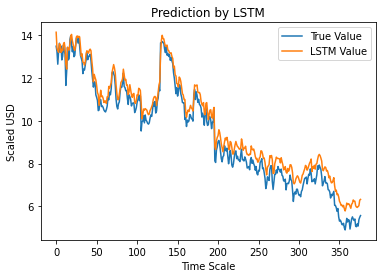

In [14]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


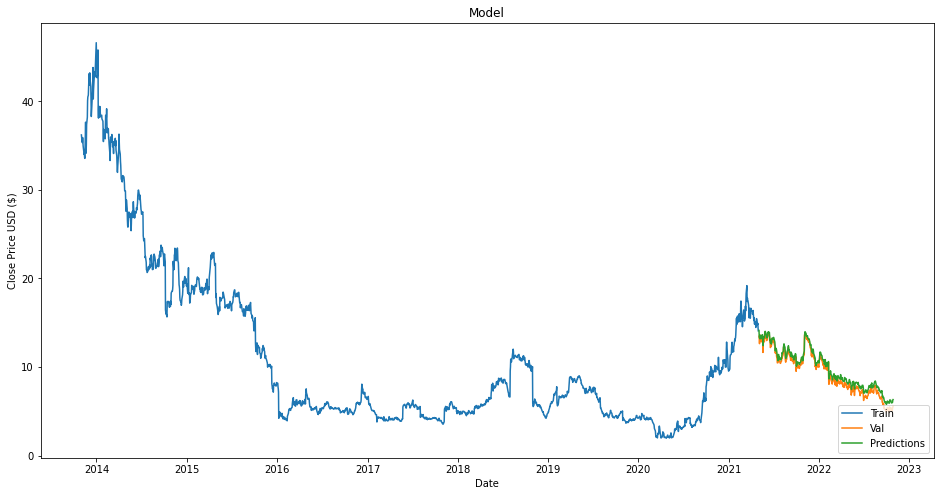

In [15]:
data = df.filter(['Close'])
train = data[:len(trainX)]
validation = data[len(trainX):]
validation['Predictions'] = y_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()